In [1]:
import pandas as pd
import numpy as np
#import psycopg2
import os
import glob
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import wfdb
import statsmodels.api as sm
import matplotlib.image as mpimg
import tkinter as tk
from matplotlib.figure import Figure
from IPython.display import display, HTML
import csv
from collections import defaultdict
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import pickle
from sklearn.linear_model import LogisticRegression
import keras as ks
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, BatchNormalization
from keras.utils import np_utils
from keras.initializers import RandomNormal
from keras import backend as Ks
from keras import optimizers
from keras.optimizers import SGD,adam
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib as mpl
from keras.callbacks import ModelCheckpoint,CSVLogger
from numpy.random import seed

Using TensorFlow backend.


In [2]:
def dataLoader(ftrain,fvalid,ftest,fstat):
    TOTAL_PTS = 1024
    CHANNELS = 3
    fstat = './'+fstat+'.csv'
    StatDf = pd.read_csv(fstat, encoding='iso-8859-1')
    
    ftrain = './'+ftrain+'.csv'
    TrainDf = pd.read_csv(ftrain, encoding='iso-8859-1')
    N_TRAIN = int((np.shape(TrainDf)[0])/4)
    print(N_TRAIN)
    
    fvalid = './'+fvalid+'.csv'
    ValidDf = pd.read_csv(fvalid, encoding='iso-8859-1')
    N_VALID = int((np.shape(ValidDf)[0])/4)
    print(N_VALID)
    
    ftest = './'+ftest+'.csv'
    TestDf = pd.read_csv(ftest, encoding='iso-8859-1')
    N_TEST = int((np.shape(TestDf)[0])/4)
    print(N_TEST)
    
    RRMean = StatDf[StatDf['Parameter']=='RR']['Mean'].values[0]
    RRStdDev = StatDf[StatDf['Parameter']=='RR']['StdDev'].values[0]
    SpO2Mean = StatDf[StatDf['Parameter']=='SpO2']['Mean'].values[0]
    SpO2StdDev = StatDf[StatDf['Parameter']=='SpO2']['StdDev'].values[0]
    HRMean = StatDf[StatDf['Parameter']=='HR']['Mean'].values[0]
    HRStdDev = StatDf[StatDf['Parameter']=='HR']['StdDev'].values[0]
    
    
    X_TRAIN = np.zeros((N_TRAIN,TOTAL_PTS,CHANNELS), dtype=np.float32)
    Y_TRAIN = np.zeros((N_TRAIN,TOTAL_PTS,1), dtype=np.float32)
    for i in range(N_TRAIN):
        X_TRAIN[i,:,0] = (TrainDf[(4*i):(4*i+1)].values.reshape(1024,) - RRMean)/RRStdDev
        X_TRAIN[i,:,1] = (TrainDf[(4*i+1):(4*i+2)].values.reshape(1024,) - SpO2Mean)/SpO2StdDev
        X_TRAIN[i,:,2] = (TrainDf[(4*i+2):(4*i+3)].values.reshape(1024,) - HRMean)/HRStdDev
        Y_TRAIN[i,:,0]= TrainDf[(4*i+3):(4*i+4)].values.reshape(1024,)
    
    X_VALID = np.zeros((N_VALID,TOTAL_PTS,CHANNELS), dtype=np.float32)
    Y_VALID = np.zeros((N_VALID,TOTAL_PTS,1), dtype=np.float32)
    for i in range(N_VALID):
        X_VALID[i,:,0] = (ValidDf[(4*i):(4*i+1)].values.reshape(1024,) - RRMean)/RRStdDev
        X_VALID[i,:,1] = (ValidDf[(4*i+1):(4*i+2)].values.reshape(1024,) - SpO2Mean)/SpO2StdDev
        X_VALID[i,:,2] = (ValidDf[(4*i+2):(4*i+3)].values.reshape(1024,) - HRMean)/HRStdDev
        Y_VALID[i,:,0]= ValidDf[(4*i+3):(4*i+4)].values.reshape(1024,)
    
    X_TEST = np.zeros((N_TEST,TOTAL_PTS,CHANNELS), dtype=np.float32)
    Y_TEST = np.zeros((N_TEST,TOTAL_PTS,1), dtype=np.float32)
    for i in range(N_TEST):
        X_TEST[i,:,0] = (TestDf[(4*i):(4*i+1)].values.reshape(1024,) - RRMean)/RRStdDev
        X_TEST[i,:,1] = (TestDf[(4*i+1):(4*i+2)].values.reshape(1024,) - SpO2Mean)/SpO2StdDev
        X_TEST[i,:,2] = (TestDf[(4*i+2):(4*i+3)].values.reshape(1024,) - HRMean)/HRStdDev
        Y_TEST[i,:,0]= TestDf[(4*i+3):(4*i+4)].values.reshape(1024,)
    return N_TRAIN, N_VALID, N_TEST, TOTAL_PTS, CHANNELS, X_TRAIN, Y_TRAIN, X_VALID, Y_VALID, X_TEST, Y_TEST

In [3]:
N_TRAIN, N_VALID, N_TEST, TOTAL_PTS, CHANNELS, X_TRAIN, Y_TRAIN, X_VALID, Y_VALID, X_TEST, Y_TEST = dataLoader('TrainingSeg','ValidationSeg','TestSeg','parStat')

1707
446
659


In [28]:
learning_rate = 0.1
momentum = 0.0
seed(7)
model = ks.Sequential()
# Conv Layer 1
model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1, input_shape=(TOTAL_PTS,3),
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv Layer 2-11 (10 layers)
for layernum in range(10):
    model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())


# Conv Layer 12
model.add(ks.layers.Conv1D(filters=1, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('sigmoid'))

model.summary()
sgd = SGD(lr=learning_rate, momentum=momentum)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy','mse'])
EPOCHS = 500
BATCH_SIZE = 1707
csv_logger = CSVLogger('SegCNN.log')
model_checkpoint = ModelCheckpoint('SegCNN.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.fit(x=X_TRAIN, y=Y_TRAIN, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[csv_logger,model_checkpoint], validation_data=(X_VALID, Y_VALID))
print('Score on validation set')
score = model.evaluate(X_VALID, Y_VALID, batch_size=BATCH_SIZE)
print(score)
print('Score on test set')
score = model.evaluate(X_TEST, Y_TEST, batch_size=BATCH_SIZE)
print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_289 (Conv1D)          (None, 1024, 10)          160       
_________________________________________________________________
activation_289 (Activation)  (None, 1024, 10)          0         
_________________________________________________________________
batch_normalization_265 (Bat (None, 1024, 10)          40        
_________________________________________________________________
conv1d_290 (Conv1D)          (None, 1024, 10)          510       
_________________________________________________________________
activation_290 (Activation)  (None, 1024, 10)          0         
_________________________________________________________________
batch_normalization_266 (Bat (None, 1024, 10)          40        
_________________________________________________________________
conv1d_291 (Conv1D)          (None, 1024, 10)          510       
__________


Epoch 00012: val_loss improved from 0.17373 to 0.16825, saving model to SegCNN.h5
Epoch 13/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.1388 - acc: 0.8153 - mean_squared_error: 0.1388 - val_loss: 0.1634 - val_acc: 0.7885 - val_mean_squared_error: 0.1634

Epoch 00013: val_loss improved from 0.16825 to 0.16344, saving model to SegCNN.h5
Epoch 14/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.1341 - acc: 0.8244 - mean_squared_error: 0.1341 - val_loss: 0.1592 - val_acc: 0.7970 - val_mean_squared_error: 0.1592

Epoch 00014: val_loss improved from 0.16344 to 0.15916, saving model to SegCNN.h5
Epoch 15/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.1298 - acc: 0.8328 - mean_squared_error: 0.1298 - val_loss: 0.1555 - val_acc: 0.8045 - val_mean_squared_error: 0.1555

Epoch 00015: val_loss improved from 0.15916 to 0.15547, saving model to SegCNN.h5
Epoch 16/500
1707/1707 [==============================] - 0s 167us/s


Epoch 00041: val_loss improved from 0.11331 to 0.11275, saving model to SegCNN.h5
Epoch 42/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0909 - acc: 0.8880 - mean_squared_error: 0.0909 - val_loss: 0.1122 - val_acc: 0.8678 - val_mean_squared_error: 0.1122

Epoch 00042: val_loss improved from 0.11275 to 0.11218, saving model to SegCNN.h5
Epoch 43/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0905 - acc: 0.8883 - mean_squared_error: 0.0905 - val_loss: 0.1117 - val_acc: 0.8683 - val_mean_squared_error: 0.1117

Epoch 00043: val_loss improved from 0.11218 to 0.11166, saving model to SegCNN.h5
Epoch 44/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0902 - acc: 0.8887 - mean_squared_error: 0.0902 - val_loss: 0.1111 - val_acc: 0.8688 - val_mean_squared_error: 0.1111

Epoch 00044: val_loss improved from 0.11166 to 0.11114, saving model to SegCNN.h5
Epoch 45/500
1707/1707 [==============================] - 0s 167us/s


Epoch 00070: val_loss improved from 0.10182 to 0.10156, saving model to SegCNN.h5
Epoch 71/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0845 - acc: 0.8938 - mean_squared_error: 0.0845 - val_loss: 0.1013 - val_acc: 0.8764 - val_mean_squared_error: 0.1013

Epoch 00071: val_loss improved from 0.10156 to 0.10128, saving model to SegCNN.h5
Epoch 72/500
1707/1707 [==============================] - 0s 168us/step - loss: 0.0844 - acc: 0.8939 - mean_squared_error: 0.0844 - val_loss: 0.1010 - val_acc: 0.8767 - val_mean_squared_error: 0.1010

Epoch 00072: val_loss improved from 0.10128 to 0.10101, saving model to SegCNN.h5
Epoch 73/500
1707/1707 [==============================] - 0s 173us/step - loss: 0.0842 - acc: 0.8940 - mean_squared_error: 0.0842 - val_loss: 0.1008 - val_acc: 0.8769 - val_mean_squared_error: 0.1008

Epoch 00073: val_loss improved from 0.10101 to 0.10076, saving model to SegCNN.h5
Epoch 74/500
1707/1707 [==============================] - 0s 171us/s


Epoch 00099: val_loss improved from 0.09588 to 0.09568, saving model to SegCNN.h5
Epoch 100/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0817 - acc: 0.8959 - mean_squared_error: 0.0817 - val_loss: 0.0955 - val_acc: 0.8802 - val_mean_squared_error: 0.0955

Epoch 00100: val_loss improved from 0.09568 to 0.09552, saving model to SegCNN.h5
Epoch 101/500
1707/1707 [==============================] - 0s 172us/step - loss: 0.0816 - acc: 0.8959 - mean_squared_error: 0.0816 - val_loss: 0.0953 - val_acc: 0.8804 - val_mean_squared_error: 0.0953

Epoch 00101: val_loss improved from 0.09552 to 0.09531, saving model to SegCNN.h5
Epoch 102/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0815 - acc: 0.8959 - mean_squared_error: 0.0815 - val_loss: 0.0952 - val_acc: 0.8804 - val_mean_squared_error: 0.0952

Epoch 00102: val_loss improved from 0.09531 to 0.09519, saving model to SegCNN.h5
Epoch 103/500
1707/1707 [==============================] - 0s 170


Epoch 00128: val_loss improved from 0.09185 to 0.09172, saving model to SegCNN.h5
Epoch 129/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0799 - acc: 0.8972 - mean_squared_error: 0.0799 - val_loss: 0.0916 - val_acc: 0.8827 - val_mean_squared_error: 0.0916

Epoch 00129: val_loss improved from 0.09172 to 0.09164, saving model to SegCNN.h5
Epoch 130/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0799 - acc: 0.8972 - mean_squared_error: 0.0799 - val_loss: 0.0915 - val_acc: 0.8829 - val_mean_squared_error: 0.0915

Epoch 00130: val_loss improved from 0.09164 to 0.09150, saving model to SegCNN.h5
Epoch 131/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0798 - acc: 0.8972 - mean_squared_error: 0.0798 - val_loss: 0.0914 - val_acc: 0.8829 - val_mean_squared_error: 0.0914

Epoch 00131: val_loss improved from 0.09150 to 0.09141, saving model to SegCNN.h5
Epoch 132/500
1707/1707 [==============================] - 0s 170


Epoch 00157: val_loss improved from 0.08891 to 0.08884, saving model to SegCNN.h5
Epoch 158/500
1707/1707 [==============================] - 0s 167us/step - loss: 0.0787 - acc: 0.8981 - mean_squared_error: 0.0787 - val_loss: 0.0887 - val_acc: 0.8851 - val_mean_squared_error: 0.0887

Epoch 00158: val_loss improved from 0.08884 to 0.08875, saving model to SegCNN.h5
Epoch 159/500
1707/1707 [==============================] - 0s 166us/step - loss: 0.0787 - acc: 0.8981 - mean_squared_error: 0.0787 - val_loss: 0.0887 - val_acc: 0.8851 - val_mean_squared_error: 0.0887

Epoch 00159: val_loss improved from 0.08875 to 0.08867, saving model to SegCNN.h5
Epoch 160/500
1707/1707 [==============================] - 0s 168us/step - loss: 0.0786 - acc: 0.8981 - mean_squared_error: 0.0786 - val_loss: 0.0886 - val_acc: 0.8853 - val_mean_squared_error: 0.0886

Epoch 00160: val_loss improved from 0.08867 to 0.08858, saving model to SegCNN.h5
Epoch 161/500
1707/1707 [==============================] - 0s 164


Epoch 00186: val_loss improved from 0.08660 to 0.08652, saving model to SegCNN.h5
Epoch 187/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0777 - acc: 0.8988 - mean_squared_error: 0.0777 - val_loss: 0.0864 - val_acc: 0.8873 - val_mean_squared_error: 0.0864

Epoch 00187: val_loss improved from 0.08652 to 0.08645, saving model to SegCNN.h5
Epoch 188/500
1707/1707 [==============================] - 0s 168us/step - loss: 0.0776 - acc: 0.8988 - mean_squared_error: 0.0776 - val_loss: 0.0864 - val_acc: 0.8874 - val_mean_squared_error: 0.0864

Epoch 00188: val_loss improved from 0.08645 to 0.08639, saving model to SegCNN.h5
Epoch 189/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0776 - acc: 0.8988 - mean_squared_error: 0.0776 - val_loss: 0.0863 - val_acc: 0.8874 - val_mean_squared_error: 0.0863

Epoch 00189: val_loss improved from 0.08639 to 0.08631, saving model to SegCNN.h5
Epoch 190/500
1707/1707 [==============================] - 0s 170


Epoch 00215: val_loss improved from 0.08518 to 0.08513, saving model to SegCNN.h5
Epoch 216/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0768 - acc: 0.8996 - mean_squared_error: 0.0768 - val_loss: 0.0851 - val_acc: 0.8884 - val_mean_squared_error: 0.0851

Epoch 00216: val_loss improved from 0.08513 to 0.08511, saving model to SegCNN.h5
Epoch 217/500
1707/1707 [==============================] - 0s 167us/step - loss: 0.0768 - acc: 0.8996 - mean_squared_error: 0.0768 - val_loss: 0.0851 - val_acc: 0.8884 - val_mean_squared_error: 0.0851

Epoch 00217: val_loss improved from 0.08511 to 0.08505, saving model to SegCNN.h5
Epoch 218/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0768 - acc: 0.8996 - mean_squared_error: 0.0768 - val_loss: 0.0850 - val_acc: 0.8885 - val_mean_squared_error: 0.0850

Epoch 00218: val_loss improved from 0.08505 to 0.08502, saving model to SegCNN.h5
Epoch 219/500
1707/1707 [==============================] - 0s 171


Epoch 00244: val_loss improved from 0.08416 to 0.08413, saving model to SegCNN.h5
Epoch 245/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0761 - acc: 0.9003 - mean_squared_error: 0.0761 - val_loss: 0.0841 - val_acc: 0.8895 - val_mean_squared_error: 0.0841

Epoch 00245: val_loss improved from 0.08413 to 0.08409, saving model to SegCNN.h5
Epoch 246/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0761 - acc: 0.9003 - mean_squared_error: 0.0761 - val_loss: 0.0841 - val_acc: 0.8895 - val_mean_squared_error: 0.0841

Epoch 00246: val_loss improved from 0.08409 to 0.08406, saving model to SegCNN.h5
Epoch 247/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0761 - acc: 0.9003 - mean_squared_error: 0.0761 - val_loss: 0.0840 - val_acc: 0.8895 - val_mean_squared_error: 0.0840

Epoch 00247: val_loss improved from 0.08406 to 0.08403, saving model to SegCNN.h5
Epoch 248/500
1707/1707 [==============================] - 0s 170


Epoch 00273: val_loss improved from 0.08344 to 0.08340, saving model to SegCNN.h5
Epoch 274/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0755 - acc: 0.9009 - mean_squared_error: 0.0755 - val_loss: 0.0834 - val_acc: 0.8903 - val_mean_squared_error: 0.0834

Epoch 00274: val_loss improved from 0.08340 to 0.08339, saving model to SegCNN.h5
Epoch 275/500
1707/1707 [==============================] - 0s 165us/step - loss: 0.0755 - acc: 0.9009 - mean_squared_error: 0.0755 - val_loss: 0.0834 - val_acc: 0.8904 - val_mean_squared_error: 0.0834

Epoch 00275: val_loss improved from 0.08339 to 0.08337, saving model to SegCNN.h5
Epoch 276/500
1707/1707 [==============================] - 0s 168us/step - loss: 0.0755 - acc: 0.9009 - mean_squared_error: 0.0755 - val_loss: 0.0833 - val_acc: 0.8904 - val_mean_squared_error: 0.0833

Epoch 00276: val_loss improved from 0.08337 to 0.08334, saving model to SegCNN.h5
Epoch 277/500
1707/1707 [==============================] - 0s 166


Epoch 00302: val_loss improved from 0.08285 to 0.08283, saving model to SegCNN.h5
Epoch 303/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0750 - acc: 0.9013 - mean_squared_error: 0.0750 - val_loss: 0.0828 - val_acc: 0.8911 - val_mean_squared_error: 0.0828

Epoch 00303: val_loss improved from 0.08283 to 0.08281, saving model to SegCNN.h5
Epoch 304/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0749 - acc: 0.9014 - mean_squared_error: 0.0749 - val_loss: 0.0828 - val_acc: 0.8911 - val_mean_squared_error: 0.0828

Epoch 00304: val_loss improved from 0.08281 to 0.08281, saving model to SegCNN.h5
Epoch 305/500
1707/1707 [==============================] - 0s 168us/step - loss: 0.0749 - acc: 0.9014 - mean_squared_error: 0.0749 - val_loss: 0.0828 - val_acc: 0.8911 - val_mean_squared_error: 0.0828

Epoch 00305: val_loss improved from 0.08281 to 0.08277, saving model to SegCNN.h5
Epoch 306/500
1707/1707 [==============================] - 0s 171


Epoch 00332: val_loss improved from 0.08235 to 0.08235, saving model to SegCNN.h5
Epoch 333/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0745 - acc: 0.9019 - mean_squared_error: 0.0745 - val_loss: 0.0823 - val_acc: 0.8916 - val_mean_squared_error: 0.0823

Epoch 00333: val_loss improved from 0.08235 to 0.08233, saving model to SegCNN.h5
Epoch 334/500
1707/1707 [==============================] - 0s 168us/step - loss: 0.0744 - acc: 0.9019 - mean_squared_error: 0.0744 - val_loss: 0.0823 - val_acc: 0.8916 - val_mean_squared_error: 0.0823

Epoch 00334: val_loss improved from 0.08233 to 0.08232, saving model to SegCNN.h5
Epoch 335/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0744 - acc: 0.9019 - mean_squared_error: 0.0744 - val_loss: 0.0823 - val_acc: 0.8917 - val_mean_squared_error: 0.0823

Epoch 00335: val_loss improved from 0.08232 to 0.08231, saving model to SegCNN.h5
Epoch 336/500
1707/1707 [==============================] - 0s 169


Epoch 00362: val_loss improved from 0.08204 to 0.08204, saving model to SegCNN.h5
Epoch 363/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0740 - acc: 0.9024 - mean_squared_error: 0.0740 - val_loss: 0.0820 - val_acc: 0.8921 - val_mean_squared_error: 0.0820

Epoch 00363: val_loss improved from 0.08204 to 0.08202, saving model to SegCNN.h5
Epoch 364/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0740 - acc: 0.9025 - mean_squared_error: 0.0740 - val_loss: 0.0820 - val_acc: 0.8920 - val_mean_squared_error: 0.0820

Epoch 00364: val_loss did not improve from 0.08202
Epoch 365/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0740 - acc: 0.9025 - mean_squared_error: 0.0740 - val_loss: 0.0820 - val_acc: 0.8921 - val_mean_squared_error: 0.0820

Epoch 00365: val_loss improved from 0.08202 to 0.08199, saving model to SegCNN.h5
Epoch 366/500
1707/1707 [==============================] - 0s 165us/step - loss: 0.0740 - acc: 0


Epoch 00392: val_loss did not improve from 0.08162
Epoch 393/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0736 - acc: 0.9030 - mean_squared_error: 0.0736 - val_loss: 0.0816 - val_acc: 0.8926 - val_mean_squared_error: 0.0816

Epoch 00393: val_loss improved from 0.08162 to 0.08159, saving model to SegCNN.h5
Epoch 394/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0736 - acc: 0.9030 - mean_squared_error: 0.0736 - val_loss: 0.0816 - val_acc: 0.8926 - val_mean_squared_error: 0.0816

Epoch 00394: val_loss did not improve from 0.08159
Epoch 395/500
1707/1707 [==============================] - 0s 172us/step - loss: 0.0735 - acc: 0.9030 - mean_squared_error: 0.0735 - val_loss: 0.0816 - val_acc: 0.8926 - val_mean_squared_error: 0.0816

Epoch 00395: val_loss improved from 0.08159 to 0.08157, saving model to SegCNN.h5
Epoch 396/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0735 - acc: 0.9030 - mean_squared_error: 0.0


Epoch 00422: val_loss improved from 0.08139 to 0.08139, saving model to SegCNN.h5
Epoch 423/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0732 - acc: 0.9034 - mean_squared_error: 0.0732 - val_loss: 0.0814 - val_acc: 0.8928 - val_mean_squared_error: 0.0814

Epoch 00423: val_loss improved from 0.08139 to 0.08138, saving model to SegCNN.h5
Epoch 424/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0732 - acc: 0.9034 - mean_squared_error: 0.0732 - val_loss: 0.0814 - val_acc: 0.8928 - val_mean_squared_error: 0.0814

Epoch 00424: val_loss did not improve from 0.08138
Epoch 425/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0731 - acc: 0.9034 - mean_squared_error: 0.0731 - val_loss: 0.0814 - val_acc: 0.8929 - val_mean_squared_error: 0.0814

Epoch 00425: val_loss improved from 0.08138 to 0.08137, saving model to SegCNN.h5
Epoch 426/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0731 - acc: 0

1707/1707 [==============================] - 0s 171us/step - loss: 0.0728 - acc: 0.9039 - mean_squared_error: 0.0728 - val_loss: 0.0811 - val_acc: 0.8934 - val_mean_squared_error: 0.0811

Epoch 00453: val_loss improved from 0.08114 to 0.08114, saving model to SegCNN.h5
Epoch 454/500
1707/1707 [==============================] - 0s 169us/step - loss: 0.0728 - acc: 0.9039 - mean_squared_error: 0.0728 - val_loss: 0.0812 - val_acc: 0.8932 - val_mean_squared_error: 0.0812

Epoch 00454: val_loss did not improve from 0.08114
Epoch 455/500
1707/1707 [==============================] - 0s 172us/step - loss: 0.0728 - acc: 0.9039 - mean_squared_error: 0.0728 - val_loss: 0.0811 - val_acc: 0.8933 - val_mean_squared_error: 0.0811

Epoch 00455: val_loss improved from 0.08114 to 0.08114, saving model to SegCNN.h5
Epoch 456/500
1707/1707 [==============================] - 0s 167us/step - loss: 0.0728 - acc: 0.9039 - mean_squared_error: 0.0728 - val_loss: 0.0812 - val_acc: 0.8933 - val_mean_squared_error:


Epoch 00484: val_loss improved from 0.08107 to 0.08107, saving model to SegCNN.h5
Epoch 485/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0724 - acc: 0.9044 - mean_squared_error: 0.0724 - val_loss: 0.0811 - val_acc: 0.8933 - val_mean_squared_error: 0.0811

Epoch 00485: val_loss did not improve from 0.08107
Epoch 486/500
1707/1707 [==============================] - 0s 171us/step - loss: 0.0724 - acc: 0.9044 - mean_squared_error: 0.0724 - val_loss: 0.0811 - val_acc: 0.8933 - val_mean_squared_error: 0.0811

Epoch 00486: val_loss did not improve from 0.08107
Epoch 487/500
1707/1707 [==============================] - 0s 173us/step - loss: 0.0724 - acc: 0.9044 - mean_squared_error: 0.0724 - val_loss: 0.0811 - val_acc: 0.8933 - val_mean_squared_error: 0.0811

Epoch 00487: val_loss improved from 0.08107 to 0.08107, saving model to SegCNN.h5
Epoch 488/500
1707/1707 [==============================] - 0s 170us/step - loss: 0.0724 - acc: 0.9044 - mean_squared_error: 0.0

In [31]:
df = pd.read_csv('SegCNN.log',sep=',')
print(np.shape(df))
df.head()

(500, 7)


,epoch,acc,loss,mean_squared_error,val_acc,val_loss,val_mean_squared_error
0,0,0.542081,0.289204,0.289204,0.552947,0.282221,0.282221
1,1,0.594058,0.260264,0.260264,0.582312,0.266250,0.266250
2,2,0.640164,0.235324,0.235324,0.611992,0.250745,0.250745
3,3,0.671219,0.217912,0.217912,0.638709,0.236694,0.236694
4,4,0.695217,0.203737,0.203737,0.664205,0.224053,0.224053


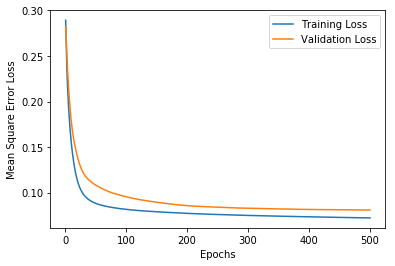

In [40]:
x = np.arange(1,501,1)
yt = df['loss'].values
yv = df['val_loss'].values
plt.plot(x,yt,label='Training Loss')
plt.plot(x,yv,label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error Loss')
plt.savefig('TrainingLog.png')
plt.show()